### Configurable Variables
Variables that can be modified in this notebook
- `input_data` — path to the input folder containing the dataset
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [2]:
input_path_folder_default = "output_datasets/SN124_A595688_Rep2/"
suppress_warnings_default = False

# SPATIAL TRANSCRIPTOMICS – IDENTIFICATION OF SVGs WITH SOMDE

Spatial transcriptomics links gene expression to tissue location. To find **spatially variable genes (SVGs)**, we use **SOMDE**, a fast method that detects spatial expression patterns using **self-organizing maps** and **statistical modeling**. This notebook demonstrates how to load data, run SOMDE, and visualize the resulting SVGs.


### Load variables from CMD

In [3]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.
* Comment out the line below if warnings are desired for debugging.

In [4]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [5]:
# use conda env from readme

2. Import necessary libraries:

In [6]:
# Import of libraries for working with spatial transcriptomics data
import os
import sys
import somoclu
from somde import plotgene
from somde import SomNode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [7]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data_folder
except NameError:
    DATA_PATH = input_path_folder_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-2].strip()

save_dir = "figures/show/somde/" + DATA_FOLDER_NAME
os.makedirs(save_dir, exist_ok=True)

Using input path: output_datasets/SN124_A595688_Rep2/


# SOMDE analaysis

### Load gene expression data
**Expecxted files**
- *Expression counts (`count.csv`)* with spots as rows and genes as columns.
- *Metadata (`idx.csv`)* containing spatial coordinates


In [9]:
# Load expression counts
df = pd.read_csv(os.path.join(DATA_PATH, "count.csv"), sep=',', index_col=0)
print("Counts shape:", df.shape)

# Load metadata / spot info
corinfo = pd.read_csv(os.path.join(DATA_PATH, "idx.csv"), sep=',', index_col=0)

# Add total counts per spot (sum across genes) with proper alignment
total_counts = df.sum(axis=1)
corinfo["total_count"] = total_counts.reindex(corinfo.index)
print(corinfo.head())

# Extract spatial coordinates
X = corinfo[['x', 'y']].values.astype(np.float32)

# Preview
print("Counts matrix shape:", df.shape)
print(df.head())
print("Spatial coordinates shape:", X.shape)
print("Metadata preview:")
print(corinfo.sort_values(by=['x', 'y'], ascending=True).head())

Counts shape: (387, 36601)
                       x     y   total_count
AAACCGTTCGTCCAGG-1   722  1308  24179.899155
AAAGGCTCTCGCGCCG-1   886  1375  26541.410022
AAAGGGATGTAGCAAG-1   975   691  23970.727229
AAATTAACGGGTAGCT-1   925   912  26947.427159
AACCGAGCTTGGTCAT-1  1077   691  22456.299749
Counts matrix shape: (387, 36601)
                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACCGTTCGTCCAGG-1          0.0      0.0    0.0         0.0         0.0   
AAAGGCTCTCGCGCCG-1          0.0      0.0    0.0         0.0         0.0   
AAAGGGATGTAGCAAG-1          0.0      0.0    0.0         0.0         0.0   
AAATTAACGGGTAGCT-1          0.0      0.0    0.0         0.0         0.0   
AACCGAGCTTGGTCAT-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACCGTTCGTCCAGG-1         0.0         0.0         0.0         0.0   
AAAGGCTCTCGCGCCG-1         0.0         0.0         0.0         0.0   
AAAGGGAT

### Initialize SOM Node

This cell creates and trains a **Self-Organizing Map (SOM) node** using the spatial coordinate matrix `X`.

In [29]:
som = SomNode(X, 0.75)

using 22*22 SOM nodes for 387 points


### Visualize Initial SOM Codebook

This cell visualizes the **initial codebook** of the Self-Organizing Map (SOM).

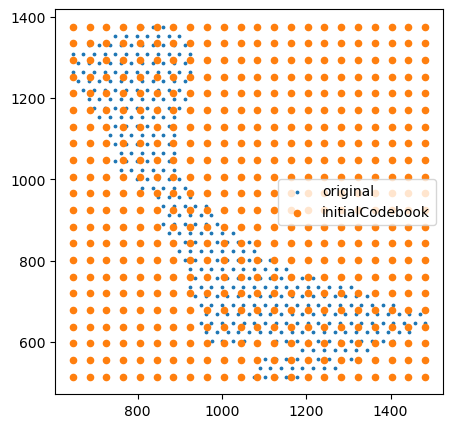

In [30]:
som.viewIniCodebook()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/ini_codebook.png",
    dpi=300,
    bbox_inches="tight"
)

### Plot the Trained SOM

This cell visualizes the **trained Self-Organizing Map (SOM)** and the mapping of data points onto it.

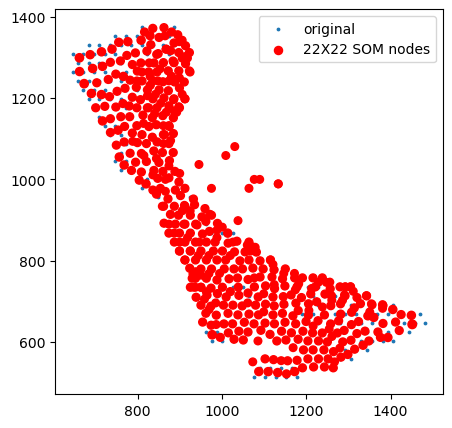

In [31]:
# Plot the SOM (creates its own figure)
som.view()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/somde_points.png",
    dpi=300,
    bbox_inches="tight"
)

### Map Expression Data onto the SOM

This cell projects the **gene expression matrix** onto the trained SOM.

In [32]:
ndf, ninfo = som.mtx(df.T)
print(ndf.shape)
print(ninfo.shape)


(36601, 349)
(349, 3)


### Visualize Gene Expression on the SOM

This cell plots the spatial distribution of selected genes on the SOM.

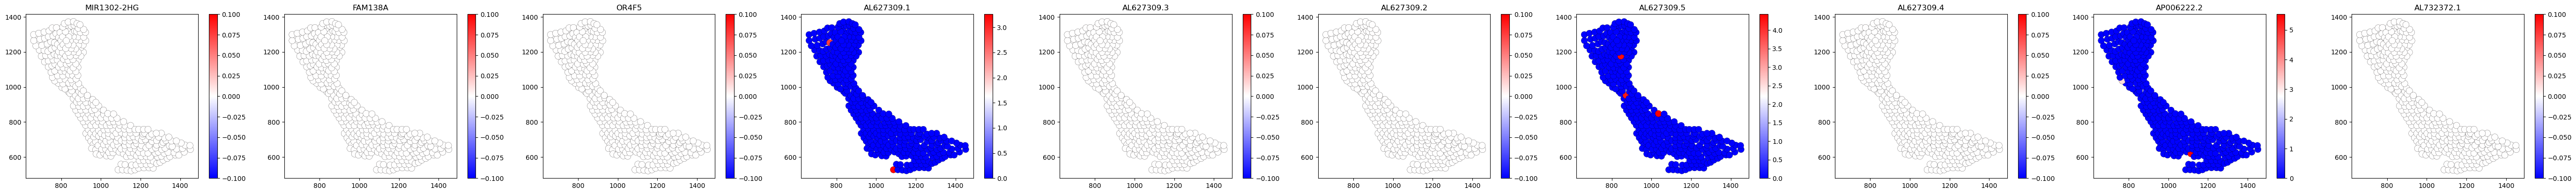

In [33]:
gene_names = df.columns

plotgene(
    X=ninfo.values,          # Uses the corrected (scaled) grid coordinates
    mtx=ndf,
    draw_list=gene_names[:10],
    result=som,
    sp=100,
    lw=0.2,
    N=10,
    plotsize=5
)

### Normalize and Run SOMDE Analysis

This cell performs **normalization** and runs the **SOMDE algorithm** on the dataset.

In [34]:
nres = som.norm()
result, SVnum =som.run()

 16%|█▋        | 6032/36601 [00:09<00:49, 614.46it/s]/Users/polakova/miniconda3/envs/myproject_x86/lib/python3.8/site-packages/somde/util.py:310: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)

Models: 100%|██████████| 10/10 [06:43<00:00, 40.32s/it]


In [35]:
result

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
31826,0.999944,4,SEMG1,71.103070,0.000050,1529.220380,3.451691,0.602252,SE,349,5.170237e-10,0.120214,0.000476,-3035.020472,1229.976759,299.243621,0.0,0.0
13574,0.999356,4,RETN,36.292993,0.000625,1510.925883,3.408142,1.311078,SE,349,3.888829e-09,0.006799,0.000536,-2998.431479,1256.548492,254.377391,0.0,0.0
30403,0.782449,4,RPL17,71.103070,0.250591,1117.109065,3.364530,0.423805,SE,349,1.450588e-04,0.005089,0.000593,-2210.797842,921.695241,195.413824,0.0,0.0
33755,0.806665,4,PIGR,139.300900,0.180693,828.358791,4.252673,0.311085,SE,349,5.071958e-04,0.020647,0.000539,-1633.297295,643.754988,184.603804,0.0,0.0
13271,0.999932,4,ZFP2,36.292993,0.000066,1569.179149,3.419437,1.341168,SE,349,1.739198e-10,0.027367,0.000573,-3114.938010,1397.222367,171.956782,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36531,0.999821,4,AC148477.4,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000745,-23385.553513,12119.988813,-415.501913,1.0,1.0
36532,0.999821,4,AC148477.1,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000731,-23385.553513,12119.988813,-415.501913,1.0,1.0
36473,0.999821,4,AC021134.2,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000686,-23385.553513,12119.988813,-415.501913,1.0,1.0
36564,0.999821,4,MT4,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000662,-23385.553513,12119.988813,-415.501913,1.0,1.0


In [47]:
coords = ninfo[['x','y']].reset_index(drop=True)
coords.columns = ["x", "y"]

expr_matrix = nres.copy()  # DataFrame: rows = nodes, columns = genes
genes = list(df.columns)

gene_node_dfs = {}
for i, gene in enumerate(genes):
    gdf = coords.copy()
    gdf["expression"] = expr_matrix.iloc[:, i]  # use iloc for DataFrame
    gdf["gene"] = gene
    gene_node_dfs[gene] = gdf

all_genes_df = pd.concat(gene_node_dfs.values(), ignore_index=True)

# all_genes_df now has columns: x, y, expression, gene
all_genes_df.sort_values(by=['gene'], ascending=True, inplace=True)


In [50]:
#all_genes_df
print(all_genes_df['gene'].unique()[100:150])

['ABHD2' 'ABHD3' 'ABHD4' 'ABHD5' 'ABHD6' 'ABHD8' 'ABI1' 'ABI2' 'ABI3'
 'ABI3BP' 'ABITRAM' 'ABL1' 'ABL2' 'ABLIM1' 'ABLIM2' 'ABLIM3' 'ABO' 'ABR'
 'ABRA' 'ABRACL' 'ABRAXAS1' 'ABRAXAS2' 'ABT1' 'ABTB1' 'ABTB2' 'AC000032.1'
 'AC000035.1' 'AC000036.1' 'AC000050.1' 'AC000058.1' 'AC000061.1'
 'AC000065.1' 'AC000065.2' 'AC000067.1' 'AC000068.1' 'AC000068.2'
 'AC000068.3' 'AC000072.1' 'AC000082.1' 'AC000085.1' 'AC000099.1'
 'AC000113.1' 'AC000120.1' 'AC000123.1' 'AC000124.1' 'AC000372.1'
 'AC000403.1' 'AC001226.1' 'AC002044.1' 'AC002056.2']


Save result data for SVGs identification.

In [42]:
all_genes_df.to_csv(DATA_PATH + "/all_genes_df.csv", index=False)
pd.DataFrame([SVnum], columns=["SVnum"]).to_csv(DATA_PATH + "/SVnum.csv", index=False)

### Visualize Spatially Variable Genes from SOMDE

This cell plots the expression patterns of selected **spatially variable genes (SVGs)**

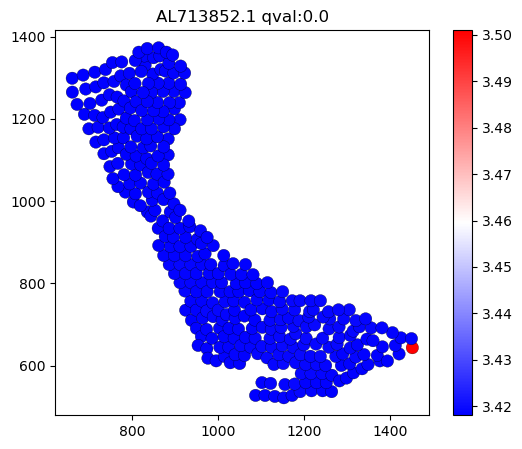

In [46]:
genes_to_display = result.g.to_list()[5:6]
plotgene(ninfo[['x','y']].values,nres.T,genes_to_display,result,sp=80,lw=0.2,plotsize=5)

### Plot Selected Spatially Variable Genes on Original Coordinates

This cell visualizes the expression patterns of a subset of **spatially variable genes (SVGs)** on the **original spatial coordinates**.

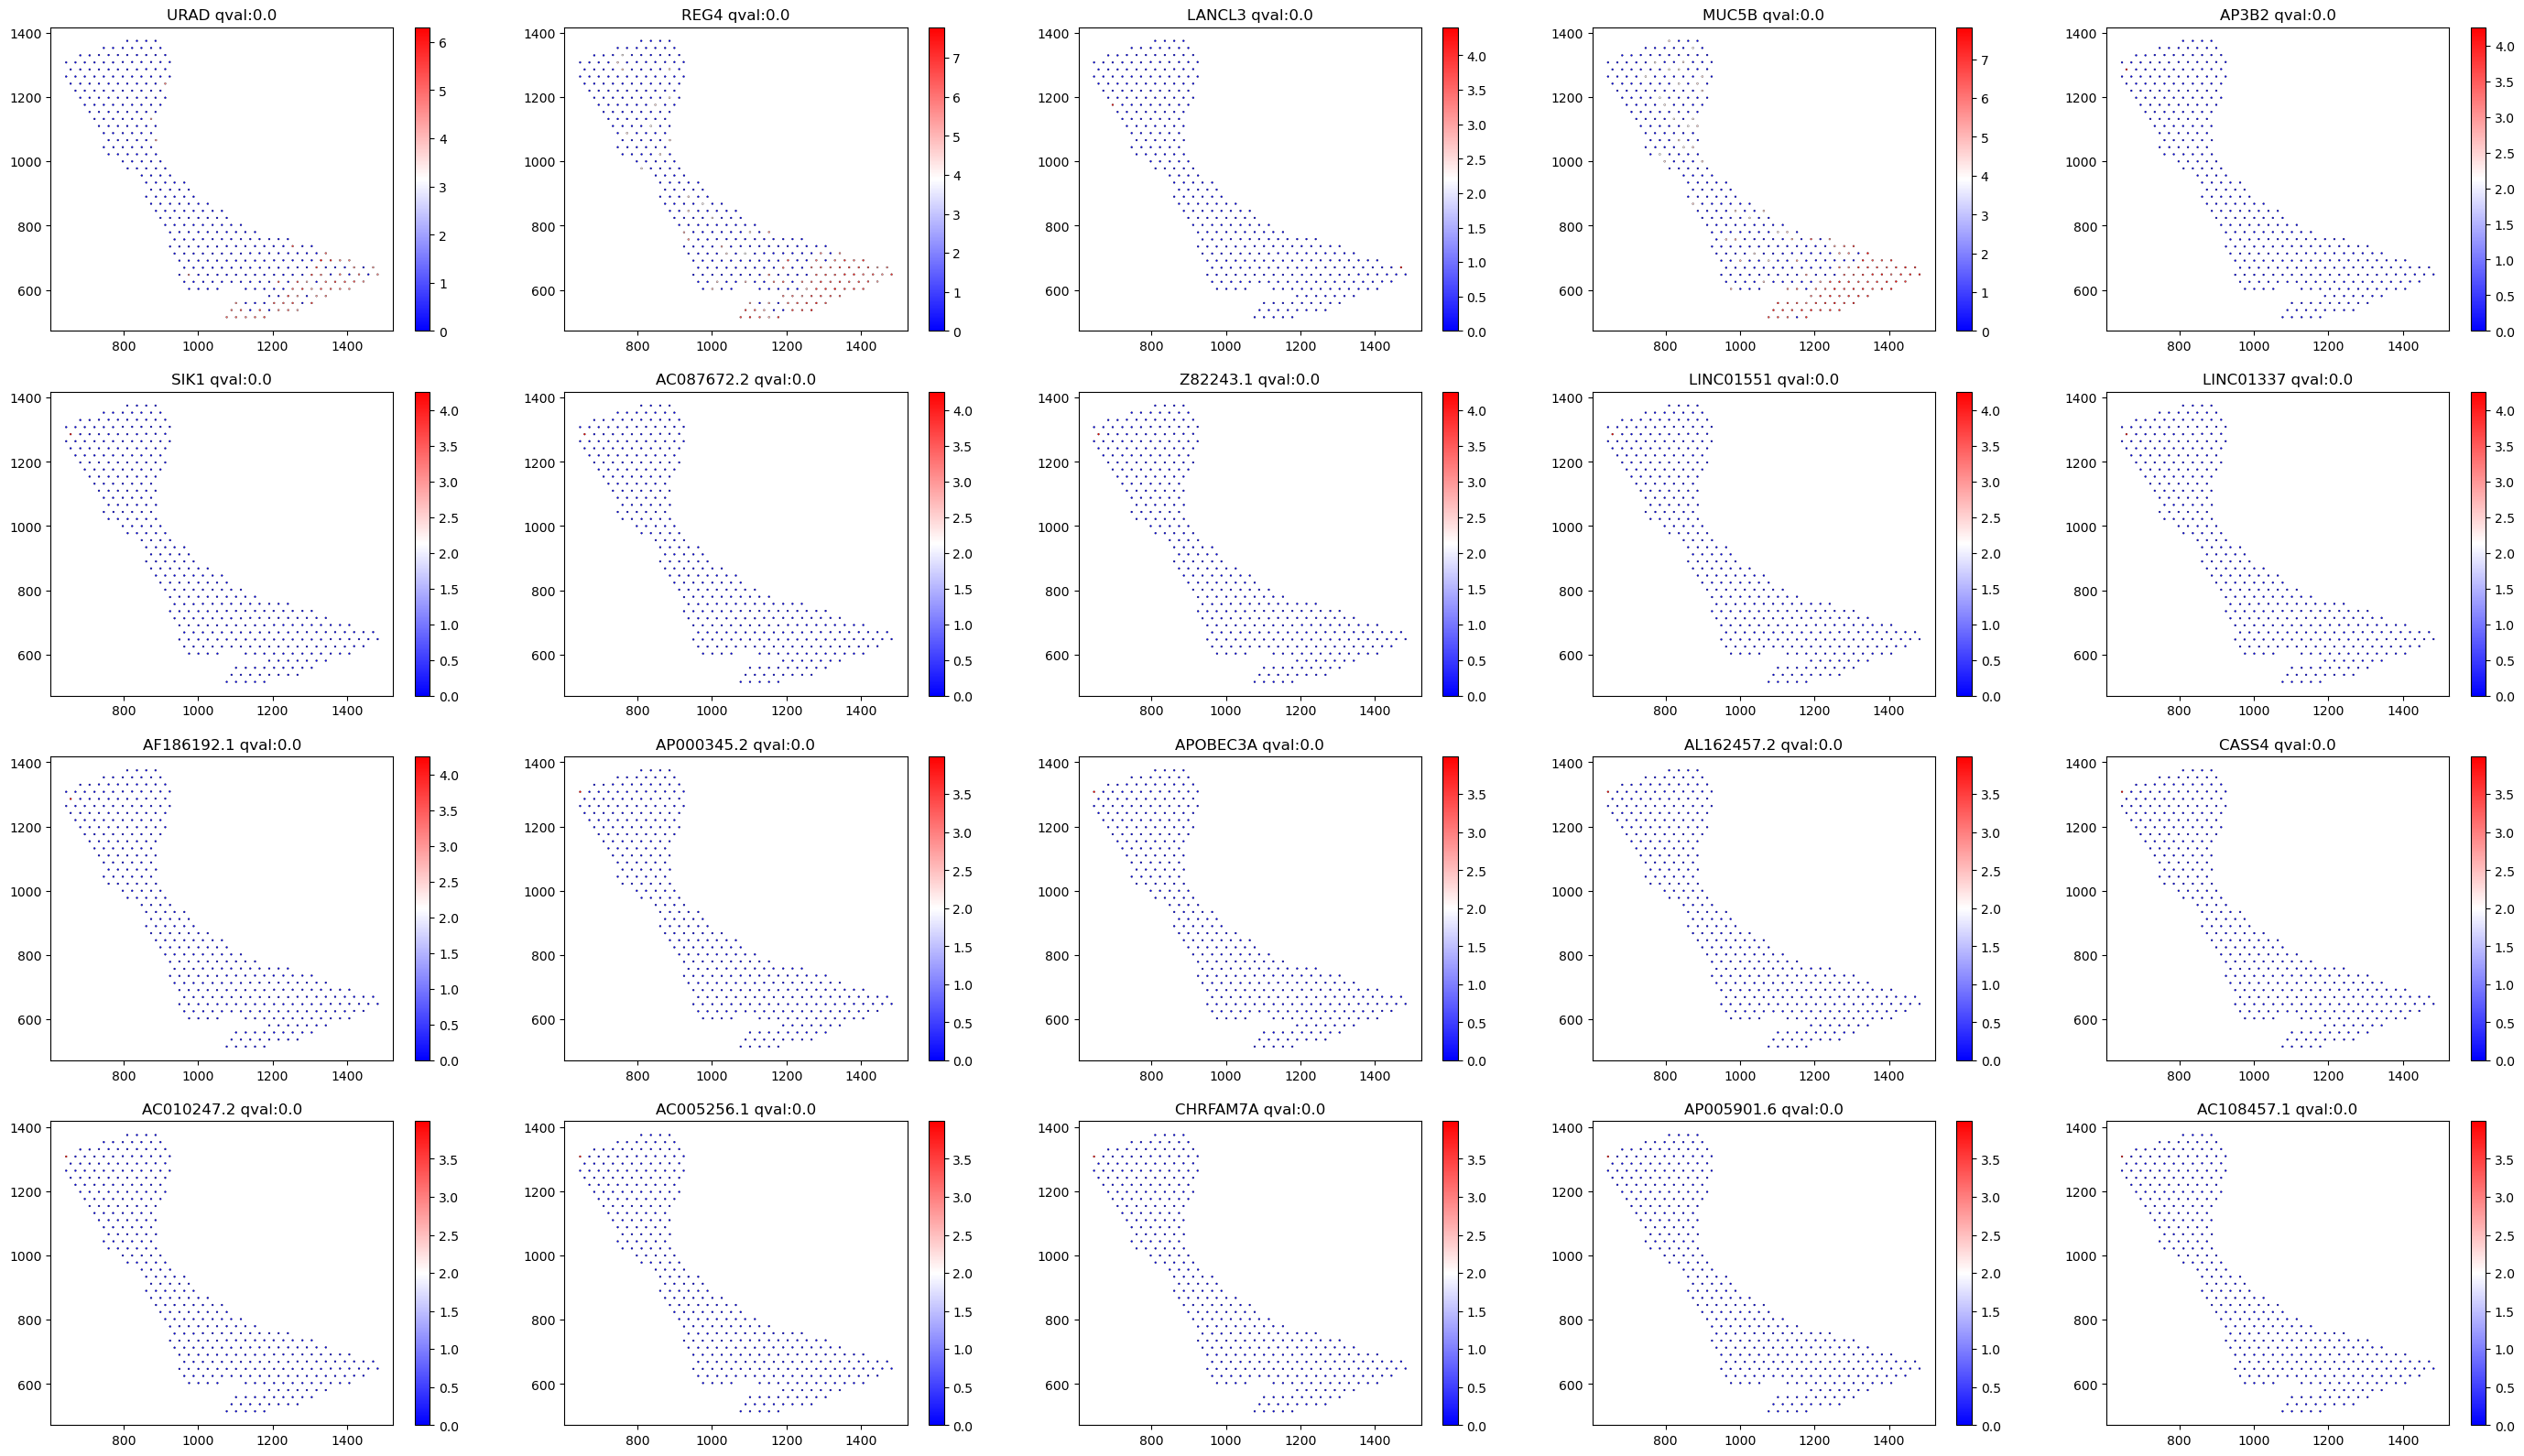

In [17]:
genes_to_display = result.g.to_list()[100:120]
plotgene(corinfo[['x','y']].values,df.T,genes_to_display,result,sp=2,lw=0.2,plotsize=5)

### Display Number of Spatially Variable Genes

In [18]:
SVnum

23441

### Display SOMDE Results Object

This cell outputs the **full SOMDE results object**.

In [51]:
result

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
31826,0.999944,4,SEMG1,71.103070,0.000050,1529.220380,3.451691,0.602252,SE,349,5.170237e-10,0.120214,0.000476,-3035.020472,1229.976759,299.243621,0.0,0.0
13574,0.999356,4,RETN,36.292993,0.000625,1510.925883,3.408142,1.311078,SE,349,3.888829e-09,0.006799,0.000536,-2998.431479,1256.548492,254.377391,0.0,0.0
30403,0.782449,4,RPL17,71.103070,0.250591,1117.109065,3.364530,0.423805,SE,349,1.450588e-04,0.005089,0.000593,-2210.797842,921.695241,195.413824,0.0,0.0
33755,0.806665,4,PIGR,139.300900,0.180693,828.358791,4.252673,0.311085,SE,349,5.071958e-04,0.020647,0.000539,-1633.297295,643.754988,184.603804,0.0,0.0
13271,0.999932,4,ZFP2,36.292993,0.000066,1569.179149,3.419437,1.341168,SE,349,1.739198e-10,0.027367,0.000573,-3114.938010,1397.222367,171.956782,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36531,0.999821,4,AC148477.4,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000745,-23385.553513,12119.988813,-415.501913,1.0,1.0
36532,0.999821,4,AC148477.1,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000731,-23385.553513,12119.988813,-415.501913,1.0,1.0
36473,0.999821,4,AC021134.2,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000686,-23385.553513,12119.988813,-415.501913,1.0,1.0
36564,0.999821,4,MT4,534.669073,0.000045,11704.486900,3.428379,0.103897,SE,349,4.819447e-09,0.109027,0.000662,-23385.553513,12119.988813,-415.501913,1.0,1.0


### Spatiallt variable genes
SOMDE considers genes with qval < 0.05 as spatially variable by default.

In [55]:
SV_genes = result[result['qval'] < 0.05]['g'].to_list()

SV_genes

['SEMG1',
 'RETN',
 'RPL17',
 'PIGR',
 'ZFP2',
 'AL713852.1',
 'AC006504.1',
 'AL445531.1',
 'ENTPD3',
 'MFSD2B',
 'IL18RAP',
 'C1QTNF9',
 'AL450311.1',
 'AL136979.1',
 'AC067930.3',
 'AC027373.1',
 'RXRG',
 'PCDHGA6',
 'SLC9A4',
 'SHOX',
 'LINC00313',
 'PIK3CD-AS1',
 'AC011365.1',
 'AC092849.2',
 'AP000759.1',
 'TNMD',
 'CPLX3',
 'AL391650.1',
 'CCDC73',
 'PTPRT',
 'LINC02068',
 'CLEC4E',
 'AC091544.4',
 'MT-CO3',
 'MT-ND4',
 'MT-ATP6',
 'MT-CO2',
 'TPSG1',
 'ADH1C',
 'MT-CO1',
 'RETNLB',
 'AC092140.2',
 'APOBEC3A',
 'CSF2',
 'AC108457.1',
 'AL162457.2',
 'CASS4',
 'AC010247.2',
 'CHRFAM7A',
 'AC005256.1',
 'AP005901.6',
 'AP000345.2',
 'AC091053.1',
 'LIN28A',
 'XKR5',
 'UCN2',
 'AC002347.1',
 'AC091180.2',
 'AC123905.1',
 'AC009119.1',
 'LINC01337',
 'AF186192.1',
 'AC087672.2',
 'AP3B2',
 'LINC01551',
 'SIK1',
 'Z82243.1',
 'MUC4',
 'AL049780.1',
 'B4GALNT2',
 'AC009495.3',
 'LRRC26',
 'ITLN1',
 'IGKC',
 'MT-ND3',
 'TFF3',
 'MT1M',
 'URAD',
 'MUC5B',
 'REG4',
 'FTL',
 'CES3',
 'AC0

In [59]:
result[result['qval'] < 0.05].sort_values('qval').head(10)


,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
31826,0.999944,4,SEMG1,71.103070,0.000050,1529.220380,3.451691,0.602252,SE,349,5.170237e-10,0.120214,0.000476,-3035.020472,1229.976759,299.243621,0.0,0.0
34007,0.539541,4,UGT2B17,139.300900,0.643416,591.834944,3.473545,0.191823,SE,349,1.289895e-03,0.024400,0.000476,-1160.249600,498.133137,93.701807,0.0,0.0
36185,0.665882,4,ZG16,272.910028,0.264143,466.061428,4.290090,0.176327,SE,349,4.760928e-03,0.107368,0.000497,-908.702568,373.550398,92.511030,0.0,0.0
35142,0.525139,4,ST6GALNAC1,139.300900,0.681738,480.246805,3.761158,0.225512,SE,349,1.322296e-03,0.024866,0.000709,-937.073323,388.229479,92.017327,0.0,0.0
13178,0.999852,4,KCNG3,36.292993,0.000143,1373.671909,3.409630,1.328077,SE,349,7.395241e-10,0.024498,0.000661,-2723.923531,1282.288654,91.383256,0.0,0.0
33882,0.498858,4,IGFBP2,139.300900,0.757371,508.825135,3.781397,0.224829,SE,349,1.254484e-03,0.023498,0.000524,-994.229983,417.576014,91.249122,0.0,0.0
34063,0.561350,4,CMBL,139.300900,0.589129,588.493074,3.557320,0.202748,SE,349,1.600184e-03,0.030698,0.000460,-1153.565860,499.515620,88.977454,0.0,0.0
35008,0.545661,4,MT1E,139.300900,0.627745,515.173183,3.545975,0.201752,SE,349,1.867418e-03,0.035442,0.000502,-1006.926078,426.868473,88.304710,0.0,0.0
23036,0.560278,4,RPL35,71.103070,0.707350,1181.462092,3.530169,0.434703,SE,349,5.062044e-04,0.009703,0.000464,-2339.503897,1093.167891,88.294201,0.0,0.0
34548,0.567791,4,MUC2,139.300900,0.573893,457.588536,4.694269,0.355041,SE,349,1.598177e-03,0.030823,0.000514,-891.756784,369.481700,88.106836,0.0,0.0
